In [2]:
import pandas as pd 
import matplotlib.pyplot as plt  
import pytorch_lightning as pl
import torch.nn as nn
import torch


# Reading CSVs

In [3]:
crude_oil_prices = pd.read_csv('../InputData/crude_oil_prices.csv')
federal_rates = pd.read_csv('../InputData/effective_federal_funds_rate.csv')
corridor_rates = pd.read_csv('../InputData/egyptian_corridor_interest_rates.csv')
housing_index = pd.read_csv('../InputData/housing_index.csv')
inflation_mom = pd.read_csv('../InputData/inflation_month_on_month.csv')
inflation_yoy = pd.read_csv('../InputData/inflation_year_on_year.csv')
news_data = pd.read_csv('../InputData/news.csv')
stock_prices = pd.read_csv('../InputData/stocks_prices_and_volumes.csv')
vix_indices = pd.read_csv('../InputData/vix_index.csv')
vixeem_indices = pd.read_csv('../InputData/vxeem_index.csv')
gold_prices = pd.read_csv('../InputData/intraday_gold.csv')
gold_prices_target = pd.read_csv('../InputData/target_gold.csv')

In [4]:
# EFFR in federal rates csv were dtype object so we need to convert them to float
federal_rates['EFFR'] = pd.to_numeric(federal_rates['EFFR'],errors='coerce')
federal_rates['EFFR'] = federal_rates['EFFR'].interpolate(method='polynomial', order=2)
print(federal_rates['EFFR'].isna().sum())
federal_rates.dropna(subset='EFFR', inplace=True)
federal_rates.dtypes

1


Date     object
EFFR    float64
dtype: object

# Converting `Date` to Object Type for Future Merging


In [5]:
dataset_names = [
    "crude_oil_prices",
    "federal_rates",
    "corridor_rates",
    "housing_index",
    "inflation_mom",
    "inflation_yoy",
    "news_data",
    "stock_prices",
    "vix_indices",
    "vixeem_indices",
    "gold_prices",
    "gold_prices_target"
]
data = [crude_oil_prices, federal_rates, corridor_rates, housing_index, inflation_mom, inflation_yoy, news_data, stock_prices, vix_indices, vixeem_indices, gold_prices, gold_prices_target]
for dataset, name in zip(data,dataset_names):
    try:
        if name == "gold_prices":
            dataset['Date'] = pd.to_datetime(dataset['Timestamp'], format='mixed', utc=True).dt.date
        elif name == "gold_prices_target":
            dataset['Date'] = pd.to_datetime(dataset['date'], format='mixed', utc=True).dt.date
        else:
            dataset['Date'] = pd.to_datetime(dataset['Date'], format='mixed', utc=True).dt.date
        print(f'{name} converted successfully')
    except Exception as e: 
        print(f"No Date Column Found: {name}")
        print("Error Message:", e)

crude_oil_prices converted successfully
federal_rates converted successfully
corridor_rates converted successfully
housing_index converted successfully
inflation_mom converted successfully
inflation_yoy converted successfully
No Date Column Found: news_data
Error Message: 'Date'
stock_prices converted successfully
vix_indices converted successfully
vixeem_indices converted successfully
gold_prices converted successfully
gold_prices_target converted successfully


# After adding `Date` to `gold_prices`

In [6]:
gold_prices

,Timestamp,24K,Date
0,2020-01-01T11:48:22+00:00,775.0,2020-01-01
1,2020-01-02T13:46:59+00:00,776.0,2020-01-02
2,2020-01-03T10:09:55+00:00,787.0,2020-01-03
3,2020-01-03T11:29:31+00:00,789.0,2020-01-03
4,2020-01-03T13:29:42+00:00,786.0,2020-01-03
...,...,...,...
3012,2023-12-28T14:20:26+00:00,3531.0,2023-12-28
3013,2023-12-29T12:44:58+00:00,3577.0,2023-12-29
3014,2023-12-30T13:01:45+00:00,3680.0,2023-12-30
3015,2023-12-30T19:22:52+00:00,3634.0,2023-12-30


# Getting `Closing Gold Price` from `gold_prices`

In [7]:
# Check for any rows that failed to convert
if gold_prices['Date'].isnull().any():
    print("There are some rows with invalid date formats.")
else:
    print("All date formats are valid.")


closing_gold_prices = gold_prices.groupby(gold_prices['Date'])['24K'].last().reset_index()
closing_gold_prices.columns = ['Date', 'Closing_Gold_Price']
if closing_gold_prices.duplicated().any(): 
    print("There are  duplicates")
else: 
    print("There are no duplicates")

closing_gold_prices.head()

All date formats are valid.
There are no duplicates


,Date,Closing_Gold_Price
0,2020-01-01,775.0
1,2020-01-02,776.0
2,2020-01-03,786.0
3,2020-01-04,791.0
4,2020-01-05,792.0


# Lagged feature from `Closing Gold Price`

In [8]:
# Creating lagged features from the closing prices
closing_gold_prices_lag = pd.DataFrame()
closing_gold_prices_lag['Date'] = closing_gold_prices['Date']
closing_gold_prices_lag['lag_1'] = closing_gold_prices['Closing_Gold_Price'].shift(1)
closing_gold_prices_lag['lag_2'] = closing_gold_prices['Closing_Gold_Price'].shift(2)

closing_gold_prices_lag.dropna(subset=['lag_1','lag_2'], inplace=True)
closing_gold_prices_lag

,Date,lag_1,lag_2
2,2020-01-03,776.0,775.0
3,2020-01-04,786.0,776.0
4,2020-01-05,791.0,786.0
5,2020-01-06,792.0,791.0
6,2020-01-07,802.0,792.0
...,...,...,...
1456,2023-12-27,3806.0,3662.0
1457,2023-12-28,3691.0,3806.0
1458,2023-12-29,3531.0,3691.0
1459,2023-12-30,3577.0,3531.0


# Merging all features into one DataFrame


In [9]:
merged = pd.merge(
    closing_gold_prices, closing_gold_prices_lag, on='Date').merge(
    federal_rates, on='Date').merge(
    corridor_rates, on='Date').merge(
    housing_index, on='Date').merge(
    inflation_mom, on='Date').merge(
    crude_oil_prices, on='Date').merge(
    inflation_yoy, on='Date').merge(
    stock_prices, on='Date').merge(
    vix_indices, on='Date').merge(
    vixeem_indices, on='Date')

print(merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 56 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 1458 non-null   object 
 1   Closing_Gold_Price                                   1458 non-null   float64
 2   lag_1                                                1458 non-null   float64
 3   lag_2                                                1458 non-null   float64
 4   EFFR                                                 1458 non-null   float64
 5   Overnight Deposit Rate                               1458 non-null   float64
 6   Overnight Lending Rate                               1458 non-null   float64
 7   CSUSHPINSA                                           1458 non-null   float64
 8   Headline (m/m)                                       1458 non-null  

In [10]:
# removing the stock_13_it_&_media_close_price and stock_13_it_&_media_volume column because it does not impact the closing gold price and it has a lot of null values
merged = merged.drop(columns=['stock_13_it_&_media_close_price', 'stock_13_it_&_media_volume'])

merged = merged.interpolate(method='polynomial', order=2)
merged = merged.dropna()
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1454 entries, 2 to 1455
Data columns (total 54 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 1454 non-null   object 
 1   Closing_Gold_Price                                   1454 non-null   float64
 2   lag_1                                                1454 non-null   float64
 3   lag_2                                                1454 non-null   float64
 4   EFFR                                                 1454 non-null   float64
 5   Overnight Deposit Rate                               1454 non-null   float64
 6   Overnight Lending Rate                               1454 non-null   float64
 7   CSUSHPINSA                                           1454 non-null   float64
 8   Headline (m/m)                                       1454 non-null   floa

C:\Users\youss\AppData\Local\Temp\ipykernel_4176\649562153.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged = merged.interpolate(method='polynomial', order=2)


## Visualization

# Visualizing features using heatmap

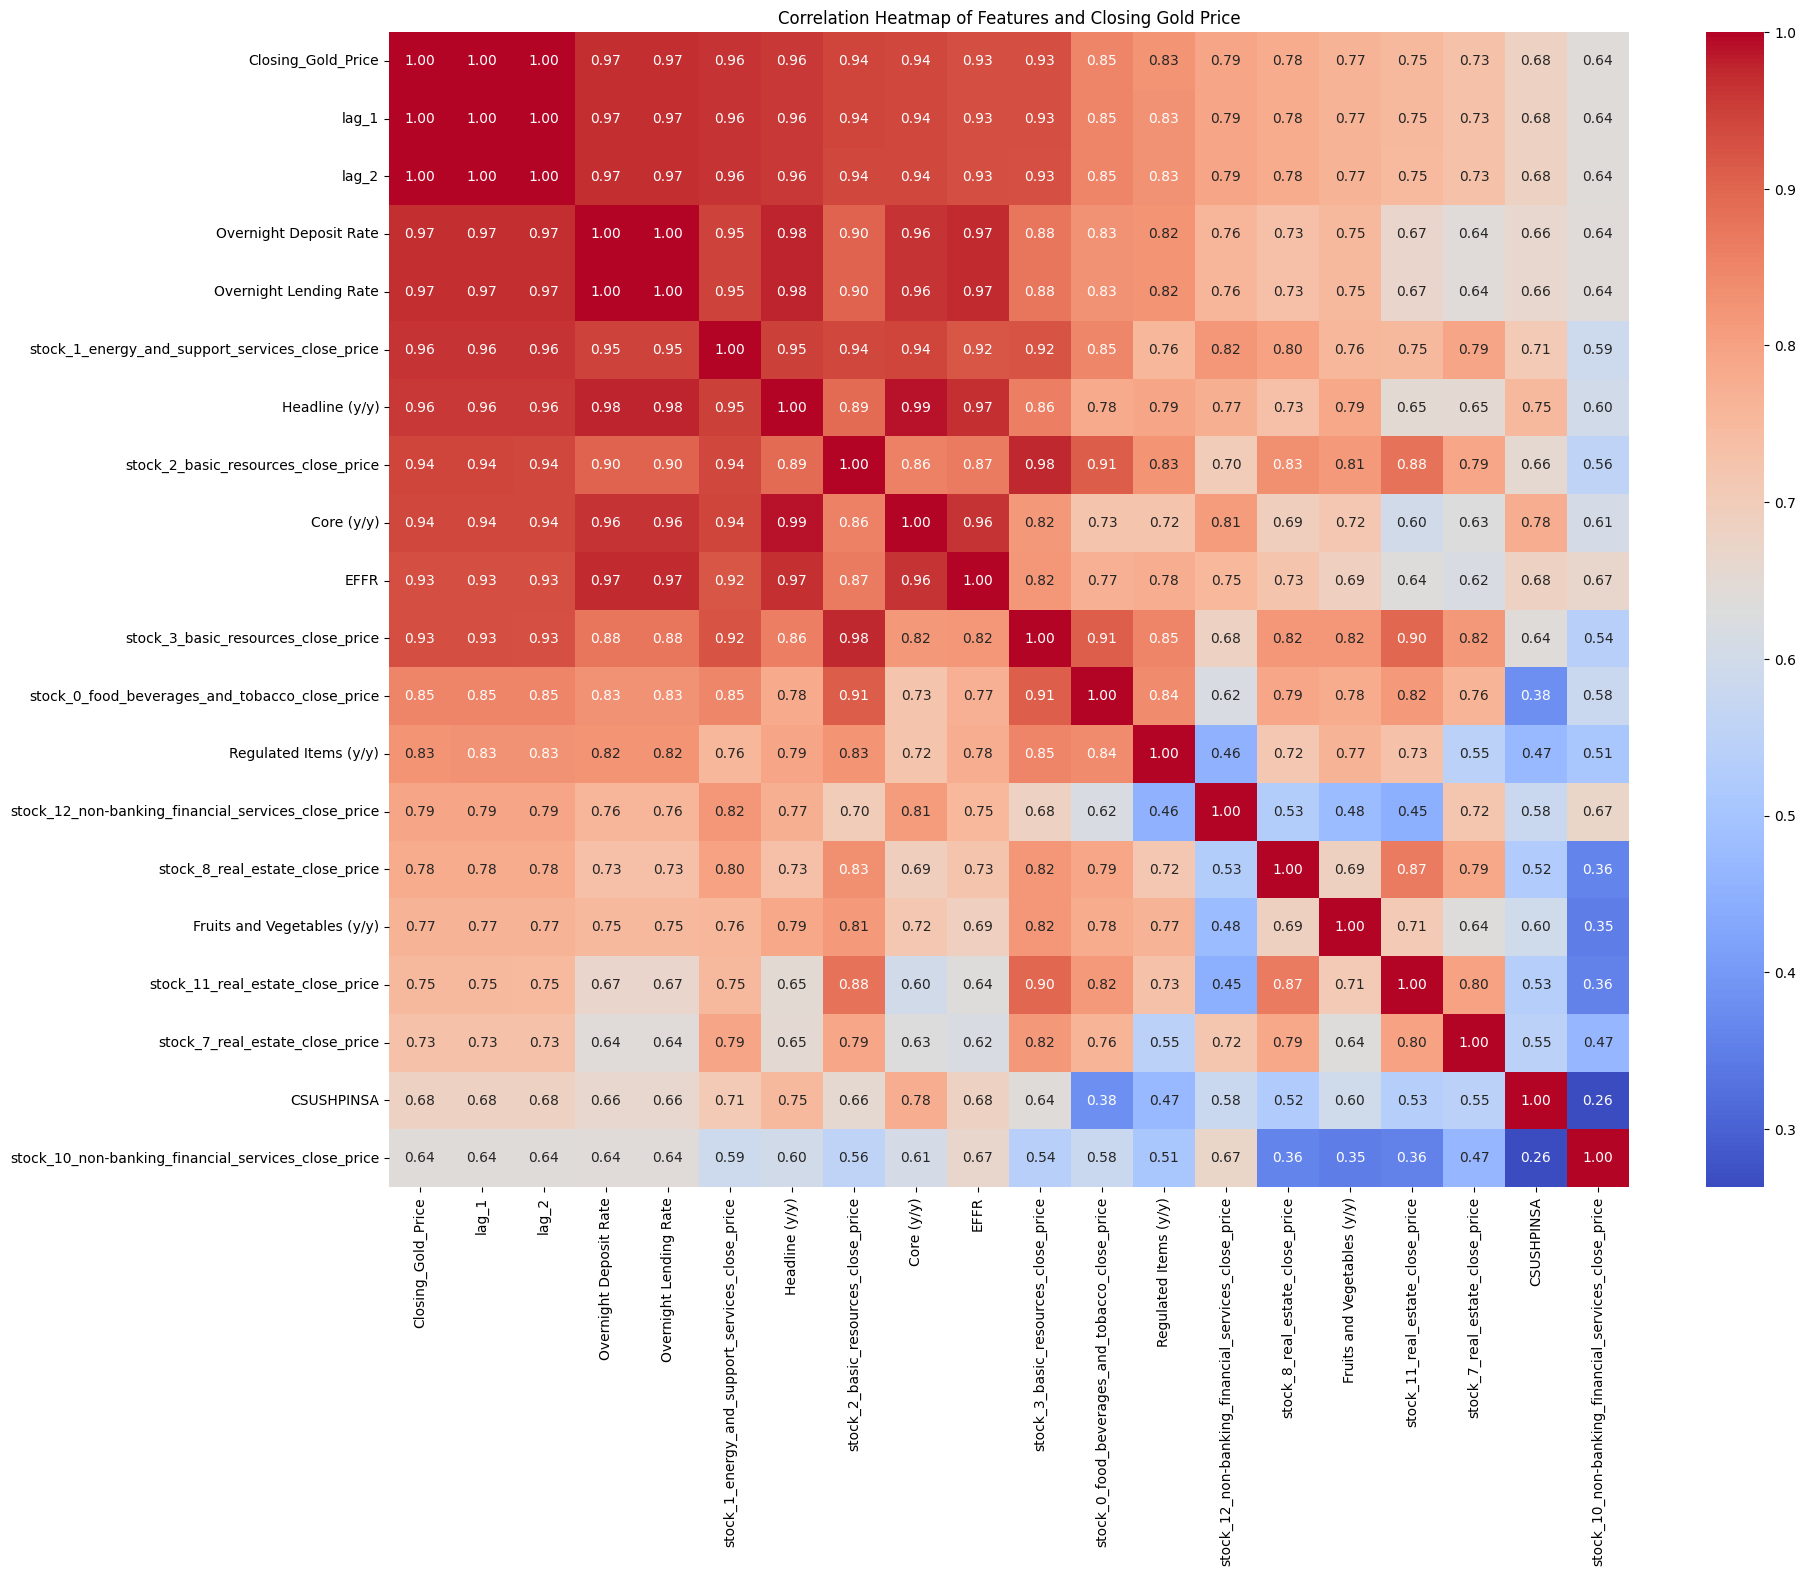

In [11]:
import seaborn as sns

# `df` is the dataset with your features and gold prices
df = merged.copy()  # Make a copy to work with

# drop non_numeric columns
df = df.select_dtypes(include=['int64', 'float64'])
# Step 2: Correlation Heatmap
plt.figure(figsize=(20,15))
correlation_matrix = df.corr()
top_feat = correlation_matrix.nlargest(20,'Closing_Gold_Price').index
# Visualizing the correlation matrix
sns.heatmap(correlation_matrix.loc[top_feat,top_feat], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features and Closing Gold Price')
plt.show()

# Visualizing features with `Closing_Gold_prices`

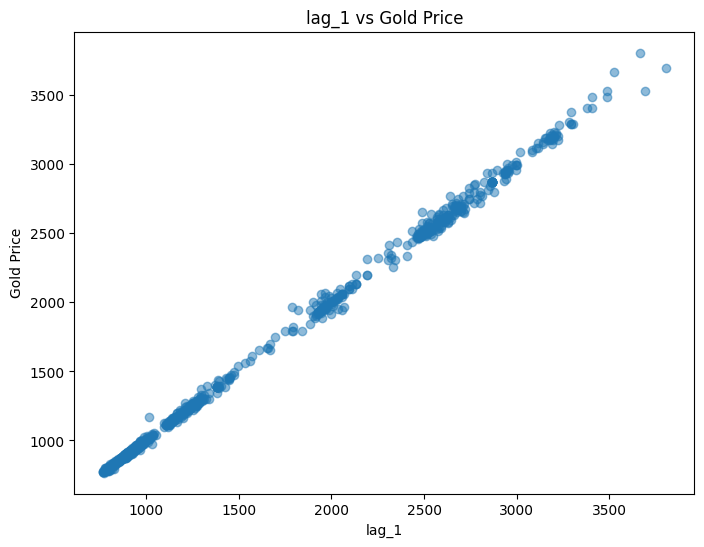

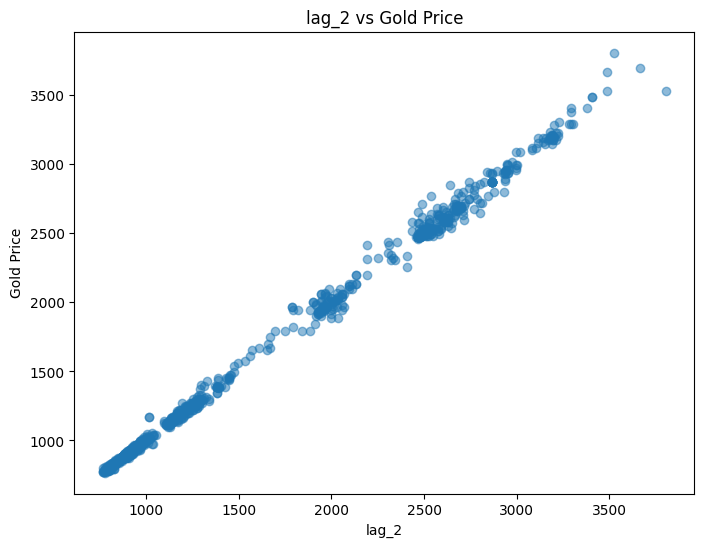

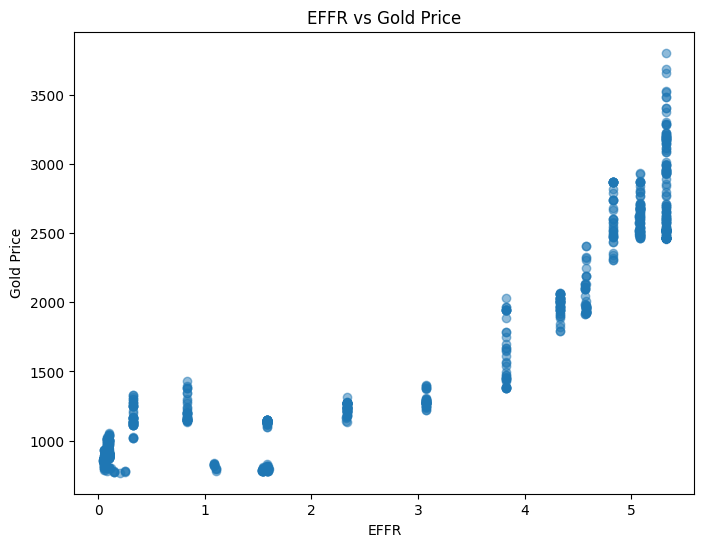

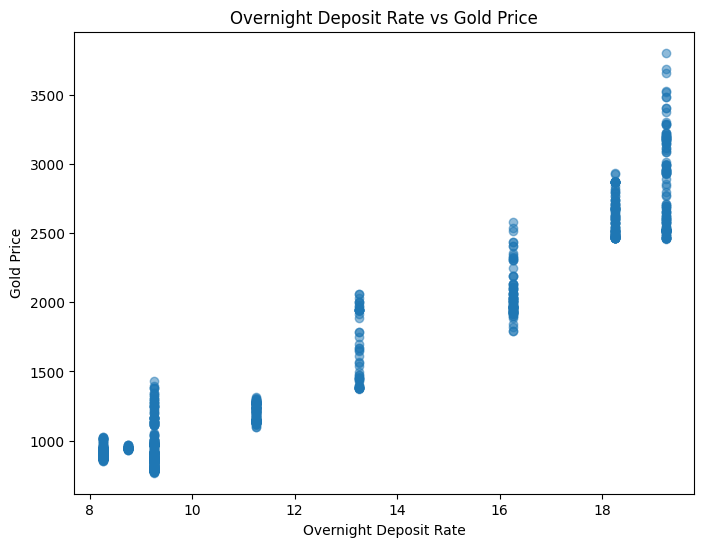

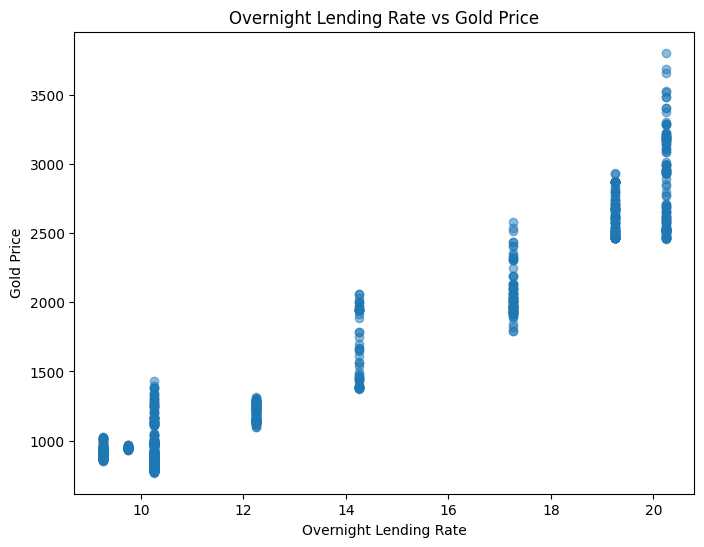

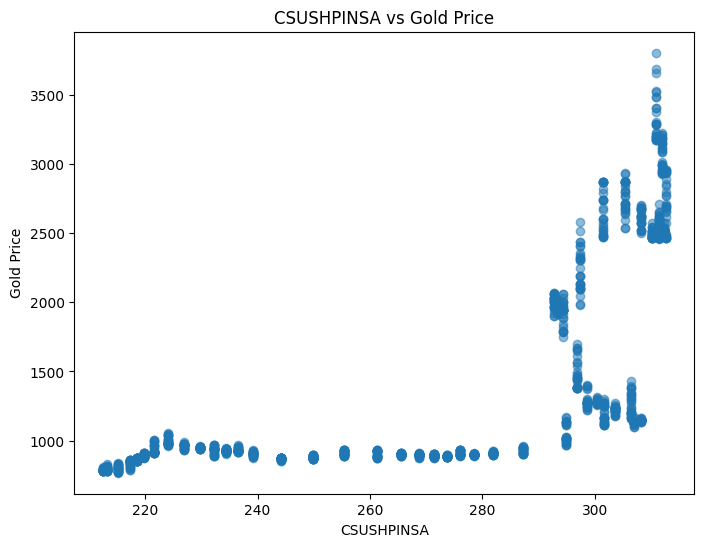

In [13]:
# Step 3: Visualizing individual feature relationships with gold price change
features = ['lag_1', 'lag_2','EFFR', 'Overnight Deposit Rate', 'Overnight Lending Rate', 'CSUSHPINSA']  # Add more as needed

for feature in features:
    plt.figure(figsize=(8,6))
    plt.scatter(df[feature], df['Closing_Gold_Price'], alpha=0.5)
    plt.title(f'{feature} vs Gold Price')
    plt.xlabel(feature)
    plt.ylabel('Gold Price')
    plt.show()

# Model

In [14]:
# final dataset with target variable(gold_prices_target)
merged = pd.merge(merged, gold_prices_target, on='Date')
merged['Date'] = pd.to_datetime(merged['Date'])

merged

,Date,Closing_Gold_Price,lag_1,lag_2,EFFR,Overnight Deposit Rate,Overnight Lending Rate,CSUSHPINSA,Headline (m/m),Core (m/m),...,OPEN_x,HIGH_x,LOW_x,CLOSE_x,OPEN_y,HIGH_y,LOW_y,CLOSE_y,date,pct_change
0,2020-01-05,792.0,791.0,786.0,1.55,9.25,10.25,212.398,0.666,0.693,...,15.01,16.20,13.13,14.02,17.70,18.36,16.83,18.31,2020-01-05,1.262626
1,2020-01-06,802.0,792.0,791.0,1.55,9.25,10.25,212.398,0.666,0.693,...,15.45,16.39,13.54,13.85,18.95,19.24,17.35,17.63,2020-01-06,0.000000
2,2020-01-07,802.0,802.0,792.0,1.55,9.25,10.25,212.398,0.666,0.693,...,13.84,14.46,13.39,13.79,17.48,17.94,15.84,16.10,2020-01-07,0.748130
3,2020-01-08,808.0,802.0,802.0,1.55,9.25,10.25,212.398,0.666,0.693,...,15.16,15.24,12.83,13.45,16.44,20.68,15.21,16.21,2020-01-08,-2.846535
4,2020-01-09,785.0,808.0,802.0,1.55,9.25,10.25,212.398,0.666,0.693,...,12.95,13.24,12.53,12.54,15.88,16.06,14.96,15.35,2020-01-09,0.254777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,2023-12-24,3525.0,3486.0,3486.0,5.33,19.25,20.25,310.847,1.413,1.313,...,13.72,13.96,13.00,13.03,20.14,20.14,17.30,17.31,2023-12-24,3.886525
1450,2023-12-25,3662.0,3525.0,3486.0,5.33,19.25,20.25,310.847,1.413,1.313,...,13.72,13.96,13.00,13.03,20.14,20.14,17.30,17.31,2023-12-25,3.932277
1451,2023-12-26,3806.0,3662.0,3525.0,5.33,19.25,20.25,310.847,1.413,1.313,...,13.77,13.80,12.96,12.99,21.63,21.63,17.22,17.34,2023-12-26,-3.021545
1452,2023-12-27,3691.0,3806.0,3662.0,5.33,19.25,20.25,310.847,1.413,1.313,...,13.02,13.04,12.37,12.43,21.43,21.43,17.13,17.29,2023-12-27,-4.334869


## Creating from `merged` DataFrame a Time Series Dataset

In [134]:
from pytorch_forecasting.data.timeseries import TimeSeriesDataSet
device = 'cuda' if torch.cuda.is_available() else 'cpu'

target = 'pct_change'
features =[]
for feat in top_feat:
    features.append(feat)

print(f'features list: {features}\nfeatures len: {len(features)} \ntarget: {target}')

# Create a time series dataset
max_encoder_length = 30  # Number of past time steps to consider
max_prediction_length = 10  # Number of future time steps to predict

merged['group_id'] = 0  # Use a constant group ID for all data points
merged['time_idx'] = range(len(merged))  # Create a sequential time index


# Create a TimeSeriesDataSet
training = TimeSeriesDataSet(
    merged,
    time_idx='time_idx',
    allow_missing_timesteps=False,
    target=target,
    group_ids=["group_id"],  # List of group ids; use a constant if not grouping
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,  # Minimum prediction length (set to 1 for next time step)
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # Include any static categorical features if available
    static_reals=[],  # Include any static real-valued features if available
    time_varying_known_categoricals=[],  # Add known categorical features if any
    time_varying_known_reals=features,  # The features that vary over time
    time_varying_unknown_categoricals=[],  # Add any unknown categorical features if available
    time_varying_unknown_reals=[],  # Add unknown real-valued features if available
    target_normalizer=None  # Set to "auto" or a specific normalizer if desired
)
print(training.get_parameters())


features list: ['Closing_Gold_Price', 'lag_1', 'lag_2', 'Overnight Deposit Rate', 'Overnight Lending Rate', 'stock_1_energy_and_support_services_close_price', 'Headline (y/y)', 'stock_2_basic_resources_close_price', 'Core (y/y)', 'EFFR', 'stock_3_basic_resources_close_price', 'stock_0_food_beverages_and_tobacco_close_price', 'Regulated Items (y/y)', 'stock_12_non-banking_financial_services_close_price', 'stock_8_real_estate_close_price', 'Fruits and Vegetables (y/y)', 'stock_11_real_estate_close_price', 'stock_7_real_estate_close_price', 'CSUSHPINSA', 'stock_10_non-banking_financial_services_close_price']
features len: 20 
target: pct_change
{'time_idx': 'time_idx', 'target': 'pct_change', 'group_ids': ['group_id'], 'weight': None, 'max_encoder_length': 30, 'min_encoder_length': 30, 'min_prediction_idx': 0, 'min_prediction_length': 1, 'max_prediction_length': 10, 'static_categoricals': [], 'static_reals': [], 'time_varying_known_categoricals': [], 'time_varying_known_reals': ['Closing_

## Splitting the Dataset to val and train

In [136]:
from pytorch_forecasting import  TemporalFusionTransformer
# Manually split the dataset using indices
train_size = int(0.8 * len(training))
val_size = len(training) - train_size


# Create training and validation datasets using slicing
train_dataset = training.get_parameters()
val_dataset = training.get_parameters()

train_dataset = TimeSeriesDataSet(
    merged.iloc[:train_size],  # Training data
    **train_dataset  # Keep other parameters the same as original dataset
)
# print(train_dataset[''])
val_dataset = TimeSeriesDataSet(
    merged.iloc[train_size:],  # Validation data
    **val_dataset
)
# Create DataLoaders
from torch.utils.data import DataLoader

batch_size =  8 # Adjust based on your system capacity
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_dataset._collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True,collate_fn=val_dataset._collate_fn)

## Initializing the Model `TemporalFusionTrasnformer` (TTF)

In [73]:
# Initialize the Temporal Fusion Transformer
model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
).to(device)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()}")


prescalers.Closing_Gold_Price.weight: 8
prescalers.Closing_Gold_Price.bias: 8
prescalers.lag_1.weight: 8
prescalers.lag_1.bias: 8
prescalers.lag_2.weight: 8
prescalers.lag_2.bias: 8
prescalers.Overnight Deposit Rate.weight: 8
prescalers.Overnight Deposit Rate.bias: 8
prescalers.Overnight Lending Rate.weight: 8
prescalers.Overnight Lending Rate.bias: 8
prescalers.stock_1_energy_and_support_services_close_price.weight: 8
prescalers.stock_1_energy_and_support_services_close_price.bias: 8
prescalers.Headline (y/y).weight: 8
prescalers.Headline (y/y).bias: 8
prescalers.stock_2_basic_resources_close_price.weight: 8
prescalers.stock_2_basic_resources_close_price.bias: 8
prescalers.Core (y/y).weight: 8
prescalers.Core (y/y).bias: 8
prescalers.EFFR.weight: 8
prescalers.EFFR.bias: 8
prescalers.stock_3_basic_resources_close_price.weight: 8
prescalers.stock_3_basic_resources_close_price.bias: 8
prescalers.stock_0_food_beverages_and_tobacco_close_price.weight: 8
prescalers.stock_0_food_beverages_an

C:\Users\youss\AppData\Roaming\Python\Python39\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\youss\AppData\Roaming\Python\Python39\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
C:\Users\youss\AppData\Roaming\Python\Python39\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pyto

In [74]:
for x,y in train_dataloader:
    print(f"data type {type(x)}, label type {type(y)}")
    print(f'data keys {x.keys()}')
    print(f'data {x}')
    print(f'label {y}')
    break
    

data type <class 'dict'>, label type <class 'tuple'>
data keys dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])
data {'encoder_cat': tensor([], size=(8, 30, 0), dtype=torch.int64), 'encoder_cont': tensor([[[-6.9434e-01, -6.9363e-01, -6.9309e-01,  ...,  3.7378e-01,
          -1.7808e-01, -3.6987e-01],
         [-6.8613e-01, -6.9363e-01, -6.9309e-01,  ...,  3.3279e-01,
          -1.7808e-01, -5.2241e-01],
         [-6.8613e-01, -6.8540e-01, -6.9309e-01,  ...,  4.0196e-01,
          -1.7808e-01, -4.0507e-01],
         ...,
         [-6.7108e-01, -6.7031e-01, -6.6970e-01,  ...,  4.3526e-01,
          -8.3525e-02, -3.5814e-01],
         [-6.7382e-01, -6.7031e-01, -6.6970e-01,  ...,  4.1733e-01,
          -8.3525e-02, -4.0507e-01],
         [-6.7382e-01, -6.7306e-01, -6.6970e-01,  ...,  2.9949e-01,
          -8.3525e-02, -4.5201e-01]],

        [[-6

## Wrapping the model in `pytorch_lightning.LightningModule`

In [113]:

class TemporalFusionTransformerModule(pl.LightningModule):
    def __init__(self, model: TemporalFusionTransformer):
        super(TemporalFusionTransformerModule, self).__init__()
        self.model = model

    def compute_loss(self, y_hat, y):
        # print(f'y_hat shape: {y_hat.shape}, y shape: {y.shape}')  # Debugging line
        y_hat_mean = y_hat.mean(dim=2)  # Shape: [8, 10]
        # print(f'y_hat_mean shape: {y_hat_mean.shape}, y shape: {y.shape}')  # Debugging line


        return nn.MSELoss()(y_hat_mean, y)

    def forward(self, x):

        out=self.model(x)
       
        return out[0] # Ensure you're calling the model directly

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.compute_loss(y_hat, y[0])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        val_loss = self.compute_loss(y_hat, y[0])
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)  # Use model parameters
        return optimizer
    
    def predict_step(self, batch, batch_idx):
        # Check if batch is a tuple and extract the data part
        if isinstance(batch, tuple):
            x = batch[0]  # Extract data (dictionary)
        else:
            x = batch  # If it's already a dictionary

        return self(x)  # Call the forward method with only data


## Using `Trainer` from `pytorch_lightning`

In [129]:
from pytorch_lightning import Trainer
# Define a trainer
trainer = Trainer(max_epochs=5, accelerator='cpu')
module = TemporalFusionTransformerModule(model).to(device)
# Fit the model
module.train()
trainer.fit(
    module,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
    )

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\youss\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [130]:
# Optionally, evaluate the model
module.eval()
trainer.validate(module, dataloaders=val_dataloader)




Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     5.575293064117432     │
└───────────────────────────┴───────────────────────────┘

Predicting: |          | 0/? [00:00<?, ?it/s]

## Predicting with the model


In [ ]:
# Get predictions
predictions = trainer.predict(module, dataloaders=val_dataloader)
predictions = predictions[0].mean(dim=2)


actual torch.Size([8, 346])
predictrd torch.Size([10])


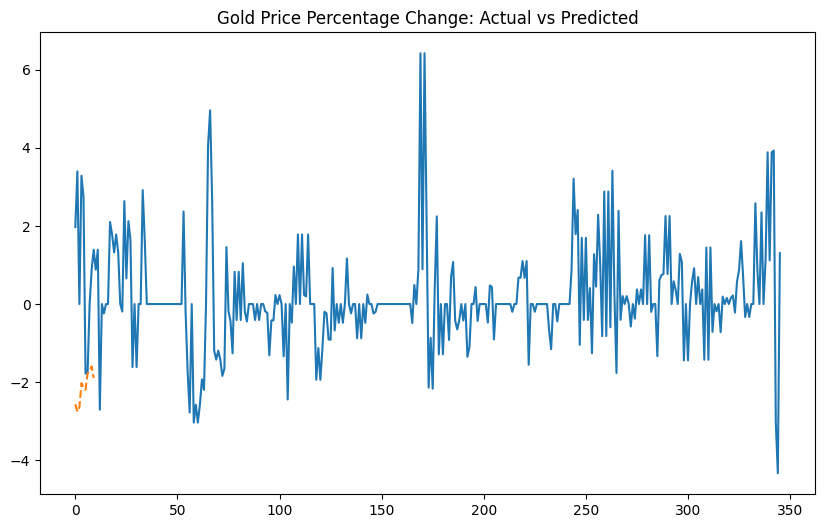

In [132]:
import torch
# Test predictions
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)],dim=1)

print('actual',actuals.shape)
print('predictrd',predictions[0].shape)
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(actuals[0], label='Actual')
plt.plot(predictions[0], label='Predicted', linestyle='--')
plt.title('Gold Price Percentage Change: Actual vs Predicted')
plt.show()
